# How to score top 3% in Kaggle’s ,,Titanic — Machine Learning from Disaster” competition

Hey, fellow machine learning enthusiasts. If you’ve ever had a try at a Kaggle competition, chances are you’re already familiar with the Titanic dataset.

This competition is about predicting whether a passenger will survive the Titanic disaster or not.

With relatively little effort it is possible to reach the top 30% of participants. Unfortunately, many of the top scorers train their model on an external dataset and thus obtain a model that classifies the test dataset with 100% accuracy. This means that you have to make an extra effort to get into the top 3%.

__Aim__ of this article:

- Explain step by step the end-to-end data pipeline that is needed to score top 3%.
- Discuss the thought process of a Machine Learning Engineer / Data Scientist in Data Cleaning and Feature Engineering.
- Make it more difficult for future participants to stand out :)

## 1. Getting the data:

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

pd.set_option('max_rows', None)

In [2]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2. Exploratory Data Analysis

Typically, it is not necessary to use each available feature. Many of them do not provide additional information for the model and increase the training time unnecessarily. For this reason it is essential to explore which features should be considered.

I would argue that most important skill of a Machine Learning Engineer/Data Scientist is to be unbiased, not assume things and to ask good questions.

In the very first step it is helpful to check if and how many entries are missing in the dataset.

### 2.1 Question 1: Does the dataset contain missing values?

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
def plot_missing_data(dataset, title):
    fig, ax = plt.subplots(figsize=(5,5))
    plt.title(title)
    sns.heatmap(dataset.isnull(), cbar=False)

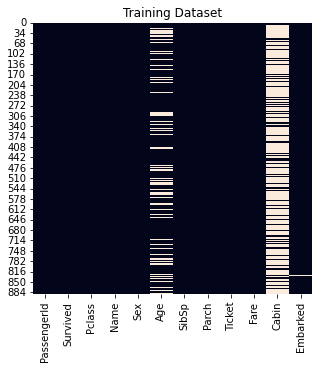

In [8]:
plot_missing_data(train_df, "Training Dataset")

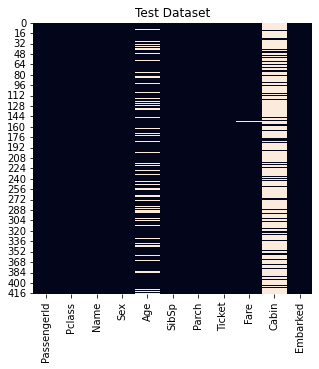

In [9]:
plot_missing_data(test_df, "Test Dataset")

### 2.1 Question 1: How many passengers survived?

In [13]:
train_df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [14]:
train_df['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

If you prefer plots you can define the function below to plot a bar chart:

In [15]:
def bar_chart_stacked(dataset, feature, stacked = True):
    survived = dataset[dataset['Survived'] == 1][feature].value_counts()
    dead = dataset[dataset['Survived'] == 0][feature].value_counts()
    df_survived_death = pd.DataFrame([survived, dead])
    df_survived_death.index = ['Passengers Survived', 'Passengers Died']
    ax = df_survived_death.plot(kind='bar', stacked=stacked, figsize=(5,5))

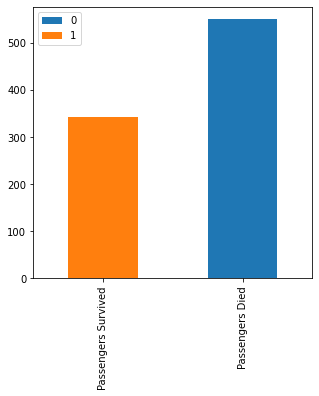

In [16]:
bar_chart_stacked(train_df,'Survived')

As expected the majority of passengers in the training data died. Only 38% survived the disaster. So the training data suffers from data imbalance but it is not severe which is why I will not consider techniques like sampling to tackle the imbalance.

### 2.2 Question 2: Is the likelihood of survival dependent on gender?

In 1912, about 110 years ago, women were generally considered to be the weaker sex that should be protected. Based on the data, we can investigate whether more women actually survived.

In [17]:
train_df['Sex'].value_counts().to_frame()

,Sex
male,577
female,314


In [18]:
train_df.groupby('Sex').Survived.mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

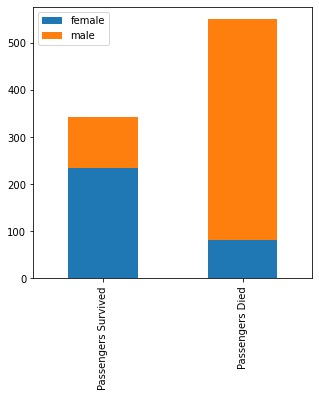

In [19]:
bar_chart_stacked(train_df,'Sex')

Here, we can clearly see that even though the majority of passenger were men, the majority of survivors were women. The key observation here is that the survival rate for female passengers is 4 times higher than the survival rate of male passengers. This seems to confirm that the phrase “women and children first” does indeed seem to have been a rule to which men adhered.

### 2.3 Question 3: Could it be that the class to which a passenger belonged correlates with the probability of survival??

In [22]:
pd.pivot_table(train_df, index='Survived', columns='Pclass', values='Ticket', aggfunc = 'count')

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


In [23]:
train_df.groupby(['Pclass']).Survived.mean().to_frame()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


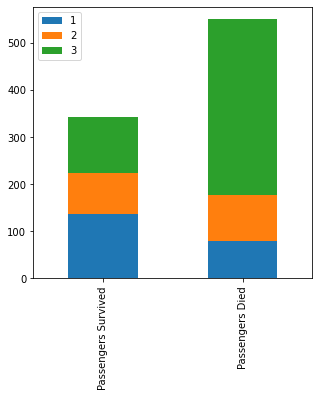

In [24]:
bar_chart_stacked(train_df,'Pclass')

From the plots and tables above it becomes clear that the Pclass is an important factor to consider.

- Most passenger had class 3 tickets, yet only 24% of class 3 passengers survived.
- Almost 63% of the passenger from class 1 survived.
- Approx 50% of the class 2 passenger survived.

However, it is yet not clear weather the class or the gender is the underlying and deciding factor. Which brings another important question:

### 2.4 Question 4: Is the higher survival rate in Class 1 due to the class itself or to a gender distribution in which female passengers dominate?

In [25]:
def bar_chart_compare(dataset, feature1, feature2=None):
    plt.figure(figsize=(5,5))
    plt.title("Survival rate by sex and class")
    g = sns.barplot(x=feature1, y='Survived', hue=feature2, ci=None, data=dataset).set_ylabel('Survival rate')

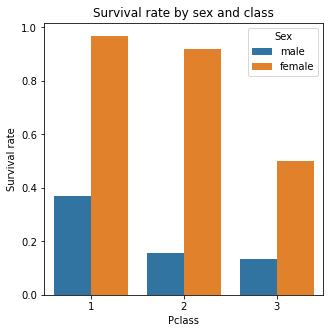

In [26]:
bar_chart_compare(train_df, 'Pclass', 'Sex')

In [27]:
train_df.groupby(['Pclass', 'Sex']).Survived.mean().to_frame()

Survived
Pclass Sex             
1      female  0.968085
       male    0.368852
2      female  0.921053
       male    0.157407
3      female  0.500000
       male    0.135447

Here, we can see that the question raised above was justified. Irrespective of the class the most important factor when it comes to surviving was gender. (At least between the two features Sex and Pclass). However, men in class 1 had a significantly higher chance of survival if they bought class 1 tickets. This just shows to say that we should keep both features as both yield insightful information that should help our model.

- Survival Rate females 1. Class: 96,8%
- Survival Rate females 2. Class: 92,1%
- Survival Rate females 3. Class: 50%
- Survival Rate male 1. Class: 36.8% (still significantly lower than 3. class females)

### 2.5 Question 5: Did a passengers age influence the chance of survival?


In [28]:
def plot_distribution(dataset, feature, title, bins=30, hist = True, fsize=(5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    ax.set_title(title)
    sns.distplot(train_df[feature], color='g', bins=bins, ax=ax)

In [29]:
def plot_kernel_density_stimate_survivor(dataset, feature1, title, fsize = (5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    ax.set_title(title)
    sns.kdeplot(dataset[feature1].loc[train_df['Survived']==1],
               shade = True, ax=ax, label='Survived').set_xlabel(feature1)
    sns.kdeplot(dataset[feature1].loc[train_df['Survived'] == 0],
               shade=True, ax=ax, label='Died')

/home/luciano/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


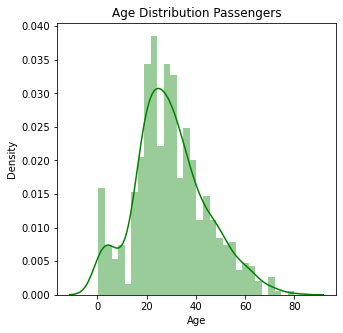

In [30]:
plot_distribution(train_df, 'Age', 'Age Distribution Passengers')

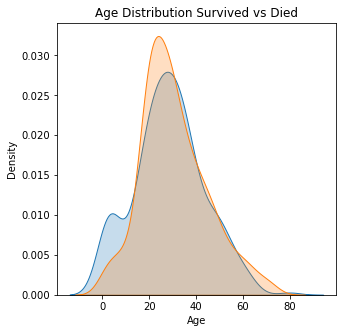

In [31]:
plot_kernel_density_stimate_survivor(train_df, 'Age', 'Age Distribution Survived vs Died')

The Histogram above shows that age follows a fairly normal distribution. Also investigating the kernel density estimate does not provide additional information except from a raise in survivors at a very young age. However, one idea might be to investigate age and sex together using a swarm plot, as it does not seem plausible that age has no influence on the chance of survival:

In [34]:
def plot_swarm_survivors(dataset, feature1, feature2, title, fize = (155)):
    fig, ax = plt.subplots(figsize=(18,5))
    # Turns off grid on the left Axis
    ax.grid(True)
    plt.xticks(list(range(0, 100, 2)))
    sns.swarmplot(y=feature1, x=feature2, hue='Survived', data=train_df).set_title(title)

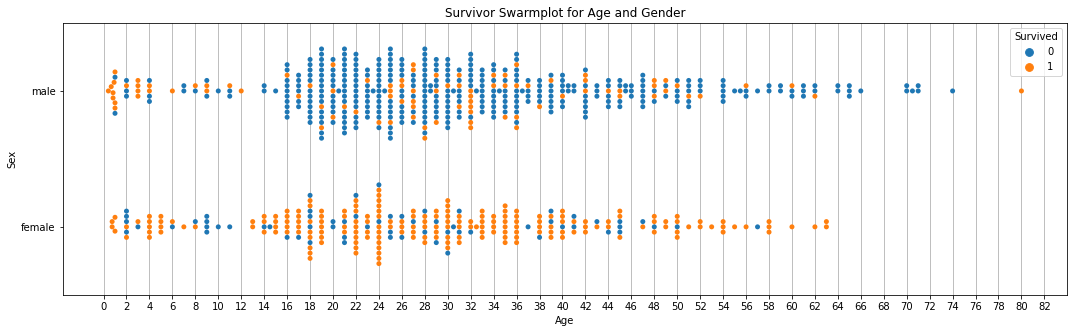

In [35]:
plot_swarm_survivors(train_df, 'Sex', 'Age', "Survivor Swarmplot for Age and Gender")

As expected age holds valuable information. The swarm plot above shows that a big portion of male survivors are passengers between 0 and 12 years of age. It’s also interesting to see that the oldest passenger 80 year old man survived.

Looking at the swarm plot below we can see how important how important the Pclass is when it comes to predicting the likelihood of survival. One additional piece of information from the swarm plot below is that the first-class did not have a lot of children. Maybe rich people get fewer kids in general?

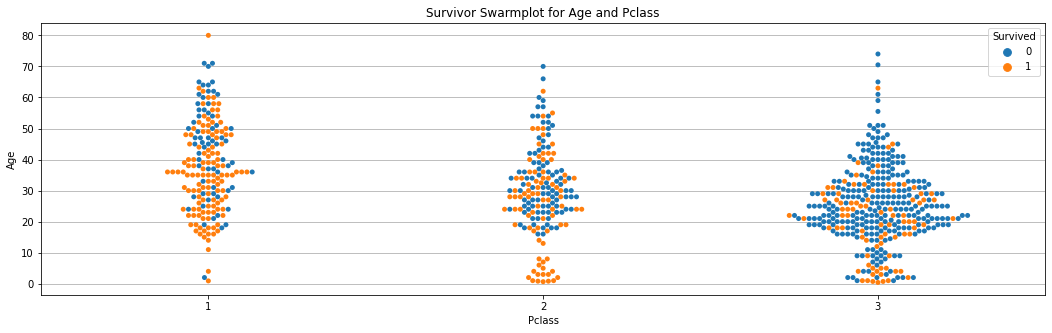

In [38]:
plot_swarm_survivors(train_df, 'Age', 'Pclass', "Survivor Swarmplot for Age and Pclass")

### 2.6 Question 6: Did paying the ticket price influence the chance of survival?

Before we start to answer this question we should look at it’s basic properties the get a better intuition for the distribution we’re dealing with:

In [39]:
train_df.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

/home/luciano/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


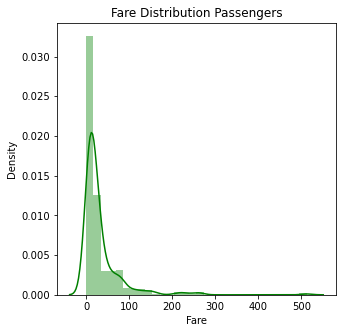

In [40]:
plot_distribution(train_df, 'Fare', 'Fare Distribution Passengers')

Fare does not follow a normal distribution and has a huge spike at the price range [0–100$].

The distribution is skewed to the left with 75% of the fare paid under 31% and a max paid fare of 512$. Depending on the model that I’m going to use it might make sense to normalize this feature. However, this aspect will be tackled later in the feature engineering section.

To better understand how this feature influences the survival rate, we could plot bar plots of Fare vs Survived. However, due to the large range of fares such as plot would not be useful for inferring useful information.

A more suited visualization would be to combine fares into categories and then plot the categories vs Survived.

In [41]:
def plot_quartiles(dataset, feature, title, categories):
    fig, axarr = plt.subplots(figsize=(5,5))
    fare_ranges = pd.qcut(dataset[feature], len(categories), labels=categories)
    axarr.set_title(title)
    sns.barplot(x=fare_ranges, y=dataset.Survived, ci=None, ax=axarr).set_ylabel("Survival rate")

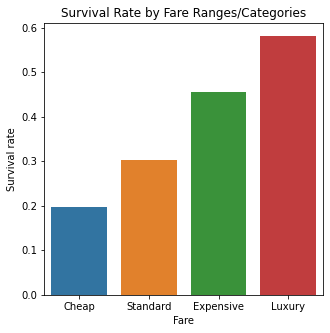

In [42]:
categories = ['Cheap', 'Standard', 'Expensive', 'Luxury']

plot_quartiles(train_df, 'Fare', "Survival Rate by Fare Ranges/Categories", categories)

As we can see the likelihood of survival is definitely influenced by the price paid.
- Cheap (0–25% of max Price): Surival Rate = 0.2 (aprox)
- Standard (25%-50% of max Price): Surival Rate = 0.3 (aprox)
- Expensive (50%-75% of max Price): Surival Rate = 0.45 (aprox)
- Luxury (75%-100% of max Price): Surival Rate = 0.55 (aprox)

Additionally, we can investigate the relationship between fare, sex and survived to further understand the importance of the feature:

/home/luciano/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 45.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/luciano/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 16.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


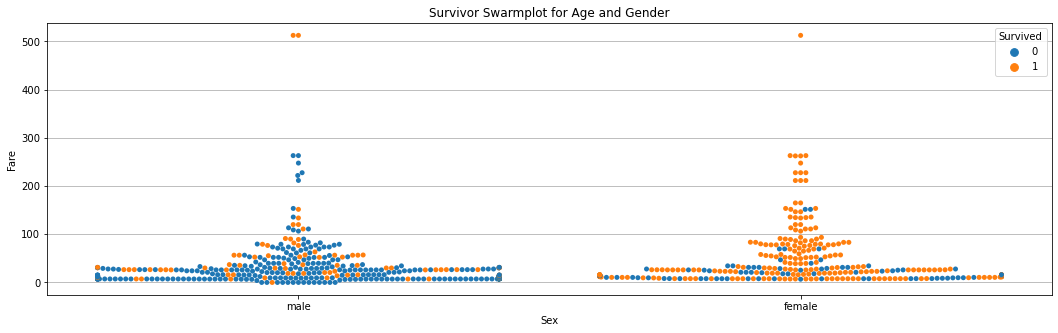

In [43]:
plot_swarm_survivors(train_df, 'Fare', 'Sex', "Survivor Swarmplot for Age and Gender")

Here, some important observations can be made:
- Irrespective of gender all passengers with a fare above 500\$ survived. 
- All male passenger that paid between 200–300\$ died
- All female passenger that paid between 200–300$ died

This could be a feature a classifier might pick up. One thing that caught my attention is that the minimum fare paid was 0.0 $. This seems highly unlikely.

We can investigate who these people were:

In [44]:
train_df.loc[train_df.Fare==0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


At first glance, I don’t notice any particular characteristic that these passengers, who have paid nothing for their fare, have in common. Since a free ride on the Titanic intuitively makes no sense, I will replace the values for the ticket price with NAN’s for these passengers. In the Feature Engineering part that follows later, we will discuss the handling of this feature separately.

In [45]:
# Replacer Fare == 0 with nan
train_df.loc[train_df['Fare'] == 0, 'Fare'] = np.NaN
test_df.loc[train_df['Fare'] == 0, 'Fare'] = np.NaN

### 2.8 Question 8: Could the place of embarkation influence the chance of survival?

My reasoning and intuition would not make me believe that the place of embarkation matters at all, however, we must force ourselves to not make any assumptions about the data.

One idea to analyze the data is to use count plots for the 3 different locations of embarkation Southampton, Cherbourg and Queenstown:

In [57]:
def show_countplot(dataset, feature, title, fsize= (5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    sns.countplot(dataset[feature], ax=ax).set_title(title)
    
def show_compare_countplot(dataset, feature1, feature2, title):
    fig, ax = plt.subplots(figsize=(5,5))
    p = sns.countplot(x=feature1, hue=feature2, data=dataset, ax=ax).set_title(title)

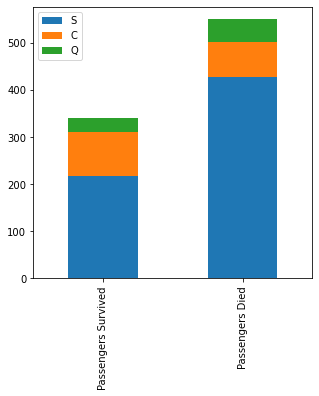

In [58]:
bar_chart_stacked(train_df, 'Embarked')

/home/luciano/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


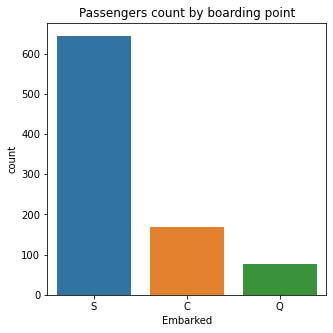

In [59]:
show_countplot(train_df, 'Embarked', "Passengers count by boarding point")

In [61]:
train_df['Embarked'].value_counts().to_frame()

,Embarked
S,644
C,168
Q,77


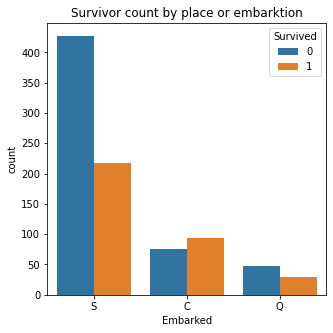

In [62]:
show_compare_countplot(train_df, 'Embarked', 'Survived', "Survivor count by place or embarktion")

In [63]:
pd.pivot_table(train_df, index='Survived', columns='Embarked', values='Ticket', aggfunc='count')

Embarked,C,Q,S
Survived,,,
0,75,47,427
1,93,30,217


We can see that the majority of passengers embarked from Southampton. However, only 33% survived the sinking of the titanic.

The highest survival rate of 55% is in the group of passengers that embarked from Cherbourg. While it is important to look at the data without making prior assumptions, however, common sense should be used at all times. Why should the place of embarkation influence the survival rate at all? Why is the likelihood of survival higher at Cherbourg?

As we know from above a better class increases the survival rate drastically. One indicator may be the percentage of 1. Class passengers that embarked at Cherbourg.